In [1]:
import numpy as np
import time
from PIL import Image

In [2]:
def bounding_box(points, screen):
    bbmin = np.floor(np.min(points, 0)).astype('int')
    bbmax = np.ceil(np.max(points, 0)).astype('int')
    bbmin = np.clip(bbmin, [0, 0], [screen.shape[0] - 1, screen.shape[1] - 1])
    bbmax = np.clip(bbmax, [0, 0], [screen.shape[0] - 1, screen.shape[1] - 1])    
    return bbmin, bbmax

In [3]:
def backfacing(tri_points):
    # Check derminant (aka 2d cross product) of a triangle sector
    M = np.concatenate(([tri_points[1] - tri_points[0]], [tri_points[2] - tri_points[0]]))
    return np.linalg.det(M) > 0 # Screen space is left-handed

In [4]:
def point_in_triangle(p, tri_points):
    for i in range(3):
        # Compute inward-pointing 2d normal of edge
        edge = tri_points[(i + 1) % 3] - tri_points[i]
        n = np.array([-edge[1], edge[0]])
        
        # The point is inside iff it lies on the correct side of all edges
        if np.dot(n, p - tri_points[i]) > 0: # Screen space is left-handed
            return False
        
    return True

In [5]:
def normalize(v):
    return v / np.linalg.norm(v)

In [6]:
def dehomogenize(V):
    return V[:, 0:-1] / np.array([V[:, -1]]).T

In [7]:
def view_matrix(cam_pos, view_dir):
    
    world_up = np.array([0, 1, 0])
    d = normalize(np.copy(view_dir))
    right = normalize(np.cross(view_dir, world_up))
    cam_up = normalize(np.cross(right, view_dir))
    
    # Assemble look-at matrix
    T = np.identity(4)
    T[0:3, 3] = -cam_pos
    
    R = np.identity(4)
    R[0:3, 0] = right
    R[0:3, 1] = cam_up
    R[0:3, 2] = -d
    
    return np.matmul(R.T, T)

In [8]:
def projection_matrix(fov_deg, near, far, screen):
    # aka frustum transform
    
    fov_rad = fov_deg * np.pi / 180.
    aspect_ratio = screen.shape[0] / screen.shape[1] # width/height
    
    top = near * np.tan(fov_rad / 2.)
    bottom = -top
    left = bottom * aspect_ratio
    right = top * aspect_ratio
    
    # Assemble projection matrx
    P = np.zeros((4, 4))
    P[0, 0] = 2. * near / (right - left)
    P[0, 2] = (right + left) / (right - left)
    P[1, 1] = 2. * near / (top - bottom)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = -(far + near) / (far - near)
    P[2, 3] = -2. * far * near / (far - near)
    P[3, 2] = -1.
    
    return P

In [9]:
def vertex_shader(V, N, MV, P):
    # Switch to 4d homogeneous coordinates
    V_hom = np.append(V, np.ones((V.shape[0], 1)), axis=1)
    
    # Compute vertex positions in camera space
    # (multiplication from right because our vertices are row vectors)
    V_cam = np.matmul(V_hom, MV.T)

    # Compute normals in camera space
    normal_transform = np.linalg.inv(MV[0:3, 0:3]).T
    N_cam = np.matmul(N, normal_transform.T)
    
    # Compute vertex positions in normalized device coordinates
    V_ndc = dehomogenize(np.matmul(V_cam, P.T))
    
    V_cam = dehomogenize(V_cam)    
    return V_cam, N_cam, V_ndc

In [10]:
def rasterize(V_screen, T, screen):
    # Pineda algorithm
    fragments = []
    
    for t in T:
        # Get screen space positions of triangle vertices (3x2 matrix)
        tri_points = V_screen[t]
        
        # TODO: Activate backface culling again
        if backfacing(tri_points):
            continue
        
        # Compute bounding box
        bbmin, bbmax = bounding_box(tri_points, screen)
        
        # Check fragments within bounding box
        for x in range(bbmin[0], bbmax[0] + 1):
            for y in range(bbmin[1], bbmax[1] + 1):
                if point_in_triangle([x, y], tri_points):
                    fragments.append([x, y])
    
    return fragments

In [11]:
def fragment_shader(fragments, screen):
    for x, y in fragments:
        screen[x, y] = [255, 255, 0]

In [12]:
def render(V, T, cam_pos, screen):
    # Clear screen
    screen[:] = np.array([64, 64, 64], dtype=np.uint8)
    
    # Compute normals
    N = np.tile(np.array([0, 0, 1]), (V.shape[0], 1))
    
    # Get model_view and projection matrix
    MV = view_matrix(cam_pos=cam_pos, view_dir=-cam_pos)
    P = projection_matrix(fov_deg=90, near=0.01, far=100., screen=screen)
    
    # Transform vertices
    V_cam, N_cam, V_ndc = vertex_shader(V, N, MV, P)
    
    # Viewport transormation
    # Invert y
    w, h, _ = screen.shape
    V_screen = V_ndc[:, 0:2] * np.array([w / 2., -h / 2.]) + np.array([w / 2., h / 2.])
    
    # Generate list of fragments
    fragments = rasterize(V_screen, T, screen)
    
    # Compute pixel colors
    screen = fragment_shader(fragments, screen)

In [13]:
def test():
    # Init screen
    height = 280
    width = height * 16 // 9
    screen = np.zeros((width, height, 3), dtype=np.uint8)
    
    # Init scene
    cam_pos = np.array([2., 2, 4.])
    
    # Load mesh
    V = np.array([[-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1], [1, -1, -1], [1, 1, -1]], dtype=np.float)
    T = np.array([[0, 1, 2], [2, 3, 0], [1, 4, 5], [5, 2, 1]], dtype=np.int)

    start = time.time()

    render(V, T, cam_pos, screen)

    seconds = time.time() - start
    print("Render took %f seconds." % seconds)

    return screen

Render took 0.225474 seconds.


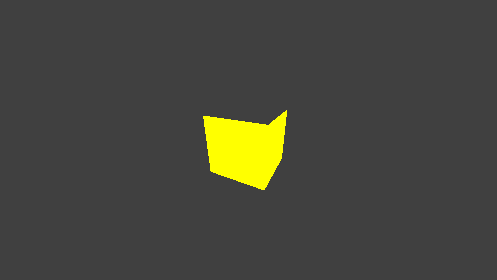

In [14]:
Image.fromarray(np.transpose(test(), (1, 0, 2)))